In [1]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
seed=10447201

Using device: cpu


## Import data

In [2]:
master = pd.read_excel(r'D:/datasets/pcuk2023_ftir_25px/master_sheet.xlsx')
slide = master['slide'].to_numpy()
core_id = master['core_id'].to_numpy()
patient_id = master['patient_id'].to_numpy()
origin_x = master['origin_x'].to_numpy()
origin_y = master['origin_y'].to_numpy()
tissue_class = master['tissue_class'].to_numpy()
tissue_class_oh = np.zeros((tissue_class.shape[0],8))
tissue_class_oh[np.arange(0,len(tissue_class_oh)),tissue_class] = 1
t_or_n = master['t_or_n'].to_numpy()
pathology_info = master['pathology_info'].to_numpy()
annotated_pixels_class = master['annotated_pixels_class'].to_numpy()
annotated_pixels_total = master['annotated_pixels_total'].to_numpy()
hdf5_filepaths = master['hdf5_filepath'].to_numpy()
annotation_filepaths = master['annotation_filepath'].to_numpy()
chemical_image_filepaths = master['chemical_image_filepath'].to_numpy()
mask_filepaths = master['mask_filepath'].to_numpy()

mean = torch.Tensor(np.load('D:/datasets/pcuk2023_ftir_25px/mean_spectrum.npy').reshape(-1,1,1))
std = torch.Tensor(np.load('D:/datasets/pcuk2023_ftir_25px/std_spectrum.npy').reshape(-1,1,1))

patch_width = patch_height = pw = ph = 25
annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0],[0,255,255],[255,255,0],])#[127,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood',"crushed","immune_infiltrate"])#,
# todo dataset metrics
print(f"Loaded {len(slide)} cores")

Loaded 7559 cores


## Define dataset, dataloaders

In [3]:
unique_pids = np.unique(patient_id)
pids_trainval, pids_test, _, _ = train_test_split(unique_pids, np.zeros_like(unique_pids), test_size=0.2, random_state=seed)
pids_train, pids_val, _, _ = train_test_split(pids_trainval, np.zeros_like(pids_trainval), test_size=0.25, random_state=seed)
where_train = np.where(np.isin(patient_id,pids_train))
where_val = np.where(np.isin(patient_id,pids_val))
where_test = np.where(np.isin(patient_id,pids_test))

for name,w in zip(["train","val","test"],[where_train,where_val,where_test]):
    print(f"For {name} dataset:","".join([f"\n\t{annotation_class_names[cls]}: {cnt}" for cls,cnt in zip(*np.unique(tissue_class[w],return_counts=True))]))

For train dataset: 
	epithelium_n: 1084
	stroma_n: 1020
	epithelium_c: 1427
	stroma_c: 756
	corpora_amylacea: 90
	blood: 122
	crushed: 13
	immune_infiltrate: 35
For val dataset: 
	epithelium_n: 336
	stroma_n: 352
	epithelium_c: 431
	stroma_c: 259
	corpora_amylacea: 37
	blood: 31
	crushed: 5
	immune_infiltrate: 5
For test dataset: 
	epithelium_n: 425
	stroma_n: 474
	epithelium_c: 344
	stroma_c: 206
	corpora_amylacea: 27
	blood: 44
	crushed: 6
	immune_infiltrate: 30


In [13]:
class chemical_patch_dataset(torch.utils.data.Dataset):
    def __init__(self, patch_paths, labels):
        self.filepaths = patch_paths
        self.labels = labels
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomVerticalFlip(p=0.5),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
        ])

    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        hf = h5py.File(self.filepaths[idx], 'r')
        patch = torch.Tensor(hf['spectra'][:]).permute(2,0,1)
        hf.close() 
        patch = self.transforms(patch)
        patch -= mean
        patch /= std
        label = torch.Tensor(self.labels[idx])
        
        return patch,label

batch_size=128
dataset_train = chemical_patch_dataset(hdf5_filepaths[where_train], tissue_class_oh[where_train])
dataset_val = chemical_patch_dataset(hdf5_filepaths[where_val], tissue_class_oh[where_val])
dataset_test = chemical_patch_dataset(hdf5_filepaths[where_test], tissue_class_oh[where_test])
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=False)
print(f"loader sizes:\n\ttrain: {len(train_loader)}\n\tval: {len(val_loader)}\n\ttest: {len(test_loader)}")

loader sizes:
	train: 36
	val: 12
	test: 13


## Define network

In [14]:
class patch_cnn(nn.Module):
    def __init__(self,):
        super().__init__()
        
        self.conv1 = nn.Conv2d(965, 32, 3, stride=1, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1, padding_mode='reflect')
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1, padding_mode='reflect')
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1, padding_mode='reflect')
        self.conv5 = nn.Conv2d(64, 128, 3, stride=1, padding=1, padding_mode='reflect')
        self.conv6 = nn.Conv2d(128, 128, 3, stride=1, padding=1, padding_mode='reflect')
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, 8)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm1d(256)
        self.activation = nn.GELU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)  
        
        self.features = nn.Sequential(
            self.conv1,self.activation,
            self.conv2,self.activation,
            self.pool,self.bn1,
            self.conv3,self.activation,
            self.conv4,self.activation,
            self.pool,self.bn2,
            self.conv5,self.activation,
            self.conv6,self.activation,
            self.pool,self.bn3
        )
        
        self.fc_stack = nn.Sequential(
            self.fc1,
            self.activation,
            self.bn4,
            self.dropout,
            self.fc2,
            self.softmax,
        )

    def forward(self, x):
        conved = self.features(x)
        logits = self.fc_stack(conved.flatten(1))
        return logits

In [15]:
model = patch_cnn()
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
l2 = 1e-5
epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=l2)
print(f"model with {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.3f}M params")

model with 0.862M params


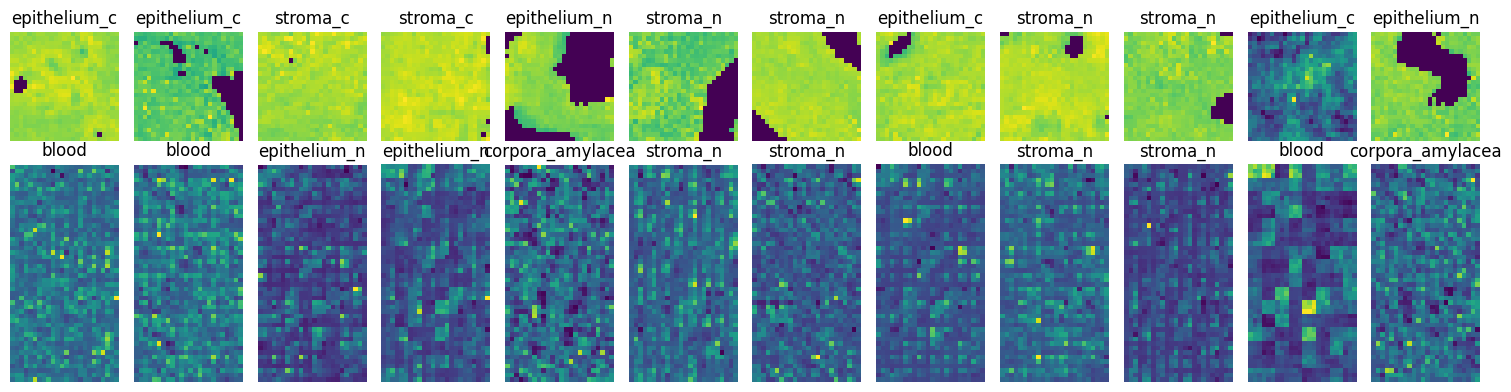

In [16]:
data,label = next(iter(train_loader))
preds = model(data.to(device)).argmax(dim=-1).detach().cpu().numpy()
features = model.features(data.to(device)).detach().cpu().numpy().reshape(batch_size,16,8,3,3).transpose(0,1,3,2,4).reshape(batch_size,16*3,8*3)
label = label.argmax(dim=1).cpu().numpy()

fig,ax = plt.subplots(2,12,figsize=(15,4),height_ratios=(0.5,1))
for x in range(12):
    ax[0,x].imshow(data[x,330]); ax[0,x].set_axis_off()
    ax[0,x].set_title(annotation_class_names[label[x]])
    ax[1,x].imshow(features[x]); ax[1,x].set_axis_off()
    ax[1,x].set_title(annotation_class_names[preds[label[x]]])
fig.tight_layout()
# todo save

## Training Loop

In [9]:
training_losses,validation_losses = [],[]
training_accs,validation_accs = [],[]
training_f1ms,validation_f1ms = [],[]
training_f1s,validation_f1s = [],[]
lr_decreases = []

In [10]:
for epoch in range(epochs):
    print(f"\n ♥ ♥ ♥ EPOCH {epoch+1} ♥ ♥ ♥")
    running_loss_train, running_loss_val = 0, 0
    train_preds,train_targets = [],[]
    val_preds,val_targets = [],[]
    
    # Train
    model.train()
    batch_frac = 42 / (len(train_loader))
    for batch_idx, (data, label) in enumerate(train_loader):
        print(f"train : {'█'*int(batch_idx*batch_frac)}", end="\r")
        data = data.to(device); label = label.to(device); #todo
        
        # Push through model and backprop
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        running_loss_train += loss.cpu().item()
        pred = out.argmax(dim=1).detach().cpu().numpy()
        actual = label.argmax(dim=1).cpu().numpy()
        train_preds.extend(pred); train_targets.extend(actual)
    print(f"train : {'█'*42}")
    # Validate
    model.eval()
    batch_frac = 42 / len(val_loader)
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            print(f"val   : {'█'*int(batch_idx*batch_frac)}", end="\r")
            data = data.to(device); label = label.to(device); 
        
            # Push through model
            out = model(data)
            loss = loss_fn(out, label)
            
            # Calculate metrics
            running_loss_val += loss.cpu().item()
            pred = out.argmax(dim=1).detach().cpu().numpy()
            actual = label.argmax(dim=1).cpu().numpy()
            val_preds.extend(pred); val_targets.extend(actual)
            
    train_acc = accuracy_score(train_targets, train_preds); training_accs.append(train_acc)
    train_f1m = f1_score(train_targets, train_preds, average='macro'); training_f1ms.append(train_f1m)
    train_f1 = f1_score(train_targets, train_preds, average=None); training_f1s.append(train_f1)
    train_loss = running_loss_train / len(dataset_train); training_losses.append(train_loss)
    
    val_acc = accuracy_score(val_targets, val_preds); validation_accs.append(val_acc)
    val_f1m = f1_score(val_targets, val_preds, average='macro'); validation_f1ms.append(val_f1m)
    val_f1 = f1_score(val_targets, val_preds, average=None); validation_f1s.append(val_f1)
    val_loss = running_loss_val / len(dataset_val); validation_losses.append(val_loss)
    print(f"val   : {'█'*42}")
    print(f"TRAIN --- | Loss: {train_loss:.4f} | OA: {train_acc:.4f} | f1: {train_f1m:.4f}")
    print(f"VAL ----- | Loss: {val_loss:.4f} | OA: {val_acc:.4f} | f1: {val_f1m:.4f}")


 ♥ ♥ ♥ EPOCH 1 ♥ ♥ ♥


KeyboardInterrupt: 

In [ ]:
# Test
running_loss_test = 0
test_preds, test_targets = [], []
model.eval()
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        data = data.to(device);
        label = label.to(device);

        # Push through model
        out = model(data)
        loss = loss_fn(out, label)

        # Calculate metrics
        running_loss_test += loss.cpu().item()
        pred = out.argmax(dim=1).detach().cpu().numpy()
        actual = label.argmax(dim=1).cpu().numpy()
        test_preds.extend(pred);
        test_targets.extend(actual)

test_acc = accuracy_score(test_targets, test_preds)
test_f1m = f1_score(test_targets, test_preds, average='macro')
test_f1 = f1_score(test_targets, test_preds, average=None)
test_loss = running_loss_test / len(dataset_test)

print(f"TEST ---- | Loss: {test_loss:.4f} | OA: {test_acc:.4f} | f1: {test_f1m:.4f}")
for cls_idx, f1 in enumerate(test_f1):
    print(f"{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4f}")

## Evaluation

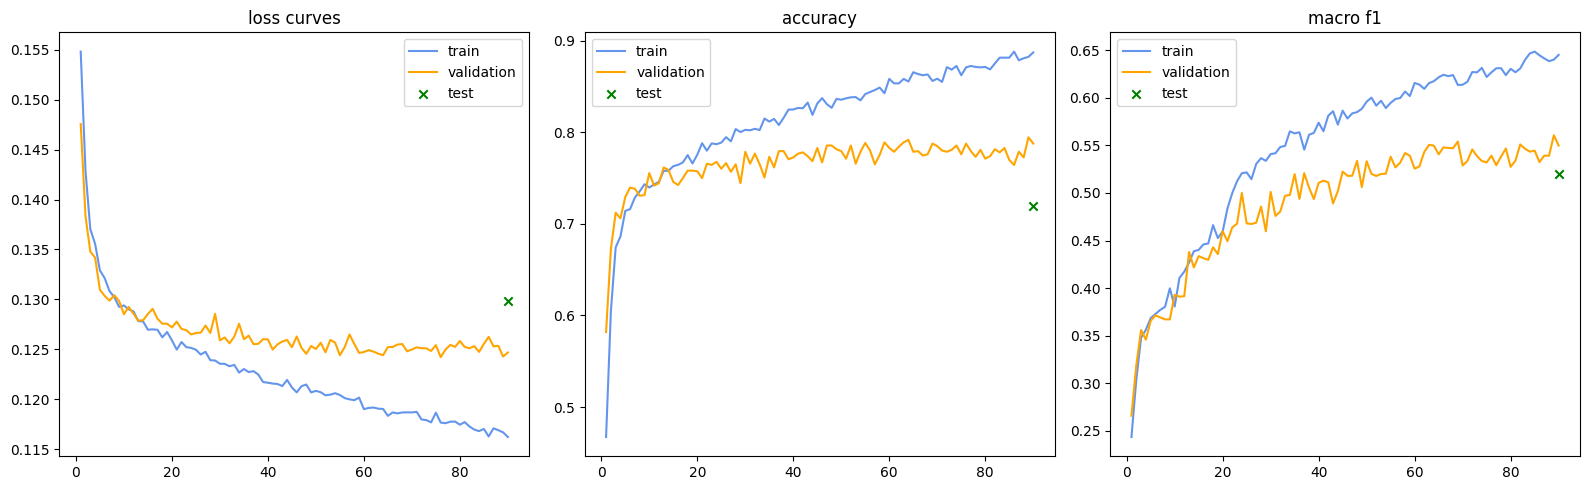

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(np.arange(1,len(training_losses)+1),np.array(training_losses),color='cornflowerblue',label="train")
ax[0].plot(np.arange(1,len(validation_losses)+1),np.array(validation_losses),color='orange',label="validation")
ax[0].scatter(len(validation_losses),test_loss,color='green',label="test",marker="x")
ax[0].set_title("loss curves"); ax[0].legend()

ax[1].plot(np.arange(1,len(training_accs)+1),np.array(training_accs),color='cornflowerblue',label="train")
ax[1].plot(np.arange(1,len(validation_accs)+1),np.array(validation_accs),color='orange',label="validation")
ax[1].scatter(len(validation_losses),test_acc,color='green',label="test",marker="x")
ax[1].set_title("accuracy"); ax[1].legend()

ax[2].plot(np.arange(1,len(training_f1ms)+1),np.array(training_f1ms),color='cornflowerblue',label="train")
ax[2].plot(np.arange(1,len(validation_f1ms)+1),np.array(validation_f1ms),color='orange',label="validation")
ax[2].scatter(len(validation_losses),test_f1m,color='green',label="test",marker="x")
ax[2].set_title("macro f1"); ax[2].legend()

for lrd in lr_decreases:
    ax[0].axvline(x=lrd, ymin=0, ymax=1, color='grey')
    ax[1].axvline(x=lrd, ymin=0, ymax=1, color='grey')
    ax[2].axvline(x=lrd, ymin=0, ymax=1, color='grey')

plt.tight_layout()
#plt.savefig('./loss_curve.png') #todo
#plt.close(fig)